In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import geopandas as gpd
import shapely.geometry
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline

dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
server='skyriver'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/lustre/scratch/dnash/temp_project/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load the list of HUC8s in Upper Colorado River Basin
fname = '../data/UpperColorado_HUC8s.txt'
HUC8_lst = pd.read_csv(fname, header=None, names=['idx', 'HUC8'], sep='\s+')
HUC8_lst = HUC8_lst.HUC8.values

In [47]:
ds_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/latest/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ds = xr.open_dataset(fname)
    ds_lst.append(ds)
    
## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
ds

<xarray.Dataset>
Dimensions:             (index: 72, start_date: 958, HUC8: 47)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2000-01-11 ... 2019-12-28
    lat                 (HUC8, start_date, index) float64 nan nan ... nan nan
    lon                 (HUC8, start_date, index) float64 nan nan ... nan nan
    time                (HUC8, start_date, index) datetime64[ns] NaT NaT ... NaT
  * HUC8                (HUC8) int64 13020102 14080101 ... 10190006 10190007
Data variables: (12/17)
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    uIVT                (HUC8, start_date, index) float64 nan nan ... nan nan
    vIVT                (HUC8, start_date, index) float64 nan nan ... nan nan
    IWV                 (HUC8, start_date, index) float64 nan nan ... nan nan
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    ar_scale            (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar                  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_scale_strict     (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_strict           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT         (HUC8, start_date) float64 nan nan nan ... nan nan nan
Attributes:
    Conventions:                CF-1/0
    history:                    Fri Jul 17 10:26:21 2020: /apps/nco-4.9.3_gnu...
    history_of_appended_files:  Fri Jul 17 10:26:21 2020: Appended file ERA5_...
    NCO:                        netCDF Operators version 4.9.3 (Homepage = ht...

In [48]:
ds_lst = []
ds_lst2 = []
for j in range(1, 6):
    AR = ds.where(ds.ar_scale == j, drop=True).ar_scale
    ## calculate monthly count (annual time series)
    da_groupby_monthly = AR.groupby('start_date.month').count(['start_date', 'HUC8'])
    ds_lst.append(da_groupby_monthly)
    
    ## calculate monthly count (interannual time series)
    monthly_count = AR.resample(start_date='1MS').count(['start_date', 'HUC8'])
    ds_lst2.append(monthly_count)
    
## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index([1, 2, 3, 4, 5], name="AR Scale"))
ds2 = xr.concat(ds_lst2, pd.Index([1, 2, 3, 4, 5], name="arscale"))

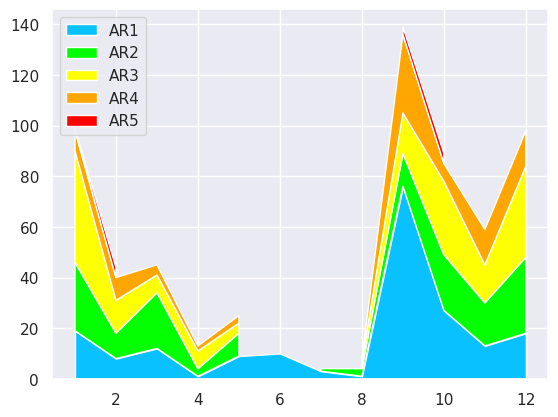

In [23]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn style
sns.set_theme()

colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
 
# Data
x=ds.month.values
y=ds.values
 
# Plot
plt.stackplot(x,y, labels=['AR1','AR2','AR3','AR4','AR5'], colors=colors)
plt.legend(loc='upper left')
plt.show()

In [79]:
ds2

<xarray.DataArray 'ar_scale' (arscale: 5, start_date: 240)>
array([[ 1., nan, nan, ..., nan,  2., nan],
       [nan, nan,  1., ..., nan,  2.,  1.],
       [ 8., nan, nan, ..., nan,  2.,  5.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * start_date  (start_date) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01
  * arscale     (arscale) int64 1 2 3 4 5

In [62]:
## create datetime labels for the x-axis
date_lst = ds2.start_date.values
xtck_lbl = []
for i, x in enumerate(date_lst):
    t = pd.to_datetime(str(x))
    xtck_lbl.append(t.strftime('%Y-%m'))
    


In [65]:
# create DataFrame
xtcks = np.arange(0, len(date_lst), 1)
df = pd.DataFrame({'AR1': ds2.sel(arscale=1).values,
                   'AR2': ds2.sel(arscale=2).values,
                   'AR3': ds2.sel(arscale=3).values,
                   'AR4': ds2.sel(arscale=4).values,
                   'AR5': ds2.sel(arscale=5).values},
                  index=xtcks)

df

,AR1,AR2,AR3,AR4,AR5
0,1.0,NaN,8.0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,1.0,2.0,3.0,2.0,NaN
...,...,...,...,...,...
235,NaN,NaN,NaN,NaN,NaN
236,NaN,1.0,NaN,NaN,NaN
237,NaN,NaN,NaN,NaN,NaN
238,2.0,2.0,2.0,NaN,NaN


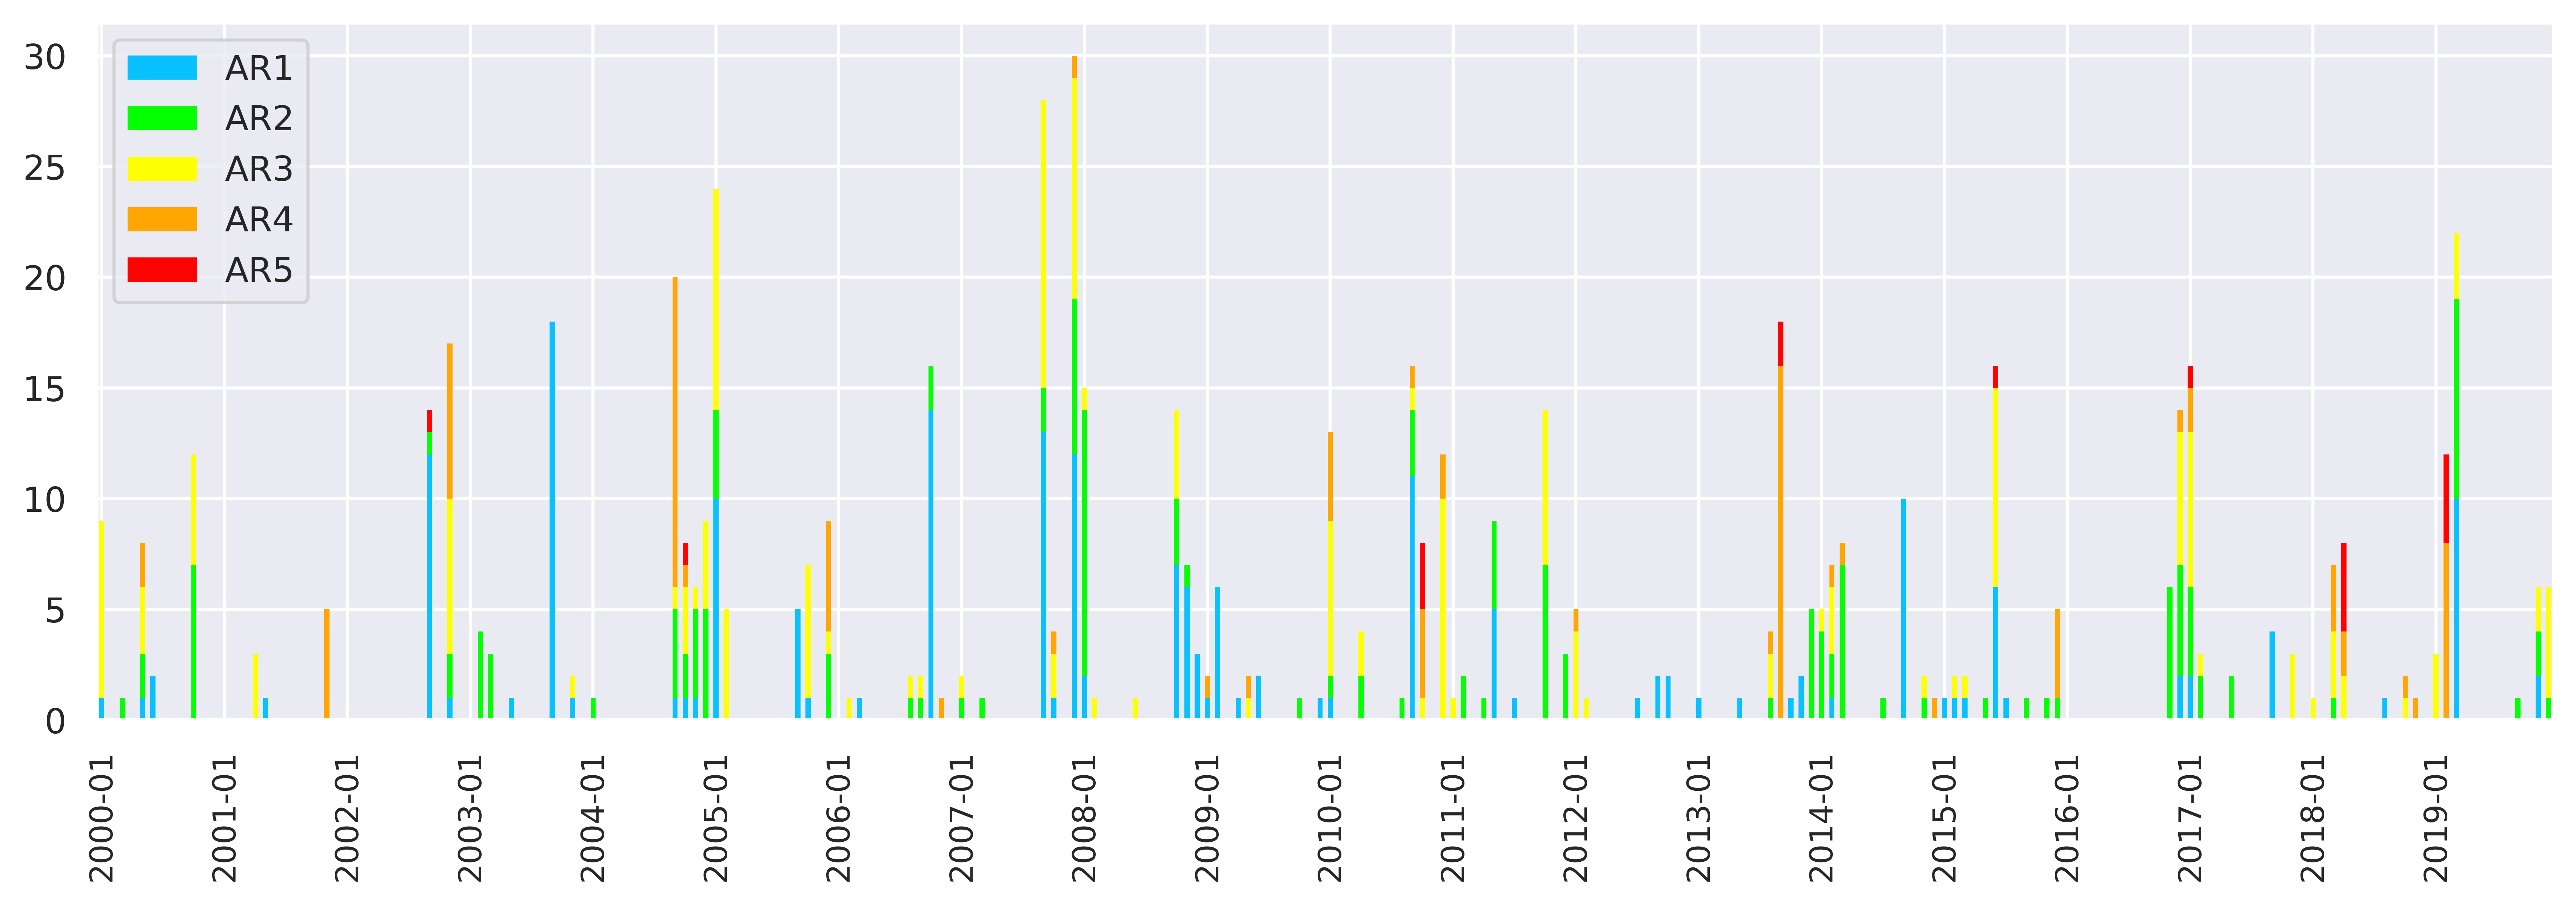

In [80]:
fig = plt.figure(figsize=(14.0, 4.0))
fig.dpi = 600
fname = path_to_figs + 'ARScale_interannual'
fmt = 'png'

nrows = 1
ncols = 1
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1], wspace=0.01, hspace=0.1)
ax = fig.add_subplot(gs[0, 0])
df.plot(kind='bar', stacked=True, color=colors, ax=ax, edgecolor='None')
# x = ds2.values
# y = xtcks
# plt.stackplot(x,y, labels=['AR1','AR2','AR3','AR4','AR5'], colors=colors)
  
ax.set_xticks(xtcks[::12]) # set the labels every year
ax.set_xticklabels(xtck_lbl[::12], fontsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=False)
plt.show()